# Font Classifier using FastAI

In [1]:
import fastai
from fastai.vision import *

In [2]:
PATH = "/home/paperspace/code/fontastic/data"


In [3]:
df_train = pd.read_csv('../train.csv')

In [4]:
df_train.head()

filename                class
0  Fahkwang-BoldItalic_300_rand_crop_5.jpg  Fahkwang-BoldItalic
1      Lora-BoldItalic_150_rand_crop_0.jpg      Lora-BoldItalic
2       Fahkwang-Light_300_rand_crop_5.jpg       Fahkwang-Light
3       Fahkwang-Italic_80_rand_crop_7.jpg      Fahkwang-Italic
4            Lato-Light_50_rand_crop_1.jpg           Lato-Light

In [5]:
df_train['path'] = df_train.filename.apply(lambda x: f"{x.split('-')[0]}/{x}")
df_train['labels'] = df_train['class'].apply(lambda x: ','.join(x.split('-')))

In [6]:
df_train.head()

filename                class  \
0  Fahkwang-BoldItalic_300_rand_crop_5.jpg  Fahkwang-BoldItalic   
1      Lora-BoldItalic_150_rand_crop_0.jpg      Lora-BoldItalic   
2       Fahkwang-Light_300_rand_crop_5.jpg       Fahkwang-Light   
3       Fahkwang-Italic_80_rand_crop_7.jpg      Fahkwang-Italic   
4            Lato-Light_50_rand_crop_1.jpg           Lato-Light   

                                               path               labels  
0  Fahkwang/Fahkwang-BoldItalic_300_rand_crop_5.jpg  Fahkwang,BoldItalic  
1          Lora/Lora-BoldItalic_150_rand_crop_0.jpg      Lora,BoldItalic  
2       Fahkwang/Fahkwang-Light_300_rand_crop_5.jpg       Fahkwang,Light  
3       Fahkwang/Fahkwang-Italic_80_rand_crop_7.jpg      Fahkwang,Italic  
4                Lato/Lato-Light_50_rand_crop_1.jpg           Lato,Light

In [7]:
df_train = df_train[['path', 'labels']]
df_train.columns = ['x', 'y']

In [8]:
data = (ImageList.from_df(df_train, path=PATH, cols=['x'], folder='training')
     .random_split_by_pct(valid_pct=0.1)
     #How to split in train/valid? -> randomly with the default 20% in valid
     .label_from_df(cols=['y'], label_delim=',')
     .transform(get_transforms(do_flip=False), size=256)
     .databunch(bs=32)
     .normalize(imagenet_stats)
)

In [9]:
df_train.y.unique()

array(['Fahkwang,BoldItalic', 'Lora,BoldItalic', 'Fahkwang,Light', 'Fahkwang,Italic', 'Lato,Light',
       'Merriweather,Black', 'Fahkwang,Medium', 'Fahkwang,LightItalic', 'MajorMonoDisplay,Regular', 'Lato,BoldItalic',
       'Lato,LightItalic', 'Fahkwang,Bold', 'Lato,BlackItalic', 'Lato,HairlineItalic', 'Lora,Italic',
       'Fahkwang,MediumItalic', 'Fahkwang,SemiBold', 'Fahkwang,ExtraLight', 'Lato,Black', 'Merriweather,BlackItalic',
       'Lato,Regular', 'Lato,Hairline', 'Lobster,Regular', 'Fahkwang,Regular', 'Fahkwang,SemiBoldItalic',
       'Lora,Regular', 'Fahkwang,ExtraLightItalic', 'Lato,Italic', 'Lora,Bold', 'Merriweather,Bold', 'Lato,Bold',
       'Merriweather,BoldItalic'], dtype=object)

In [10]:
data.classes

['Black',
 'BlackItalic',
 'Bold',
 'BoldItalic',
 'ExtraLight',
 'ExtraLightItalic',
 'Fahkwang',
 'Hairline',
 'HairlineItalic',
 'Italic',
 'Lato',
 'Light',
 'LightItalic',
 'Lobster',
 'Lora',
 'MajorMonoDisplay',
 'Medium',
 'MediumItalic',
 'Merriweather',
 'Regular',
 'SemiBold',
 'SemiBoldItalic']

In [11]:
data.device

device(type='cuda')

In [12]:
from torch.cuda import get_device_name

In [13]:
torch.cuda.current_device()

0

In [14]:
ds = data.train_ds

In [15]:
len(ds.y)

900

In [16]:
len(data.valid_ds.y)

99

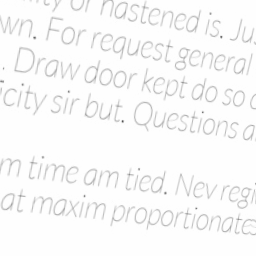

In [17]:
img,label = ds[411]
img

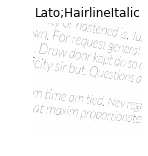

In [18]:
img.show(figsize=(2,2), title=label)


In [19]:
learn = create_cnn(data, models.resnet34, metrics=fbeta)

In [20]:
learn.crit = nn.BCEWithLogitsLoss

In [21]:
data.batch_size = 32

In [22]:
df_train.head()

x                    y
0  Fahkwang/Fahkwang-BoldItalic_300_rand_crop_5.jpg  Fahkwang,BoldItalic
1          Lora/Lora-BoldItalic_150_rand_crop_0.jpg      Lora,BoldItalic
2       Fahkwang/Fahkwang-Light_300_rand_crop_5.jpg       Fahkwang,Light
3       Fahkwang/Fahkwang-Italic_80_rand_crop_7.jpg      Fahkwang,Italic
4                Lato/Lato-Light_50_rand_crop_1.jpg           Lato,Light

In [23]:
df_train.loc[df_train['x'] == 'MajorMonoDisplay/MajorMonoDisplay-Regular_80_rand_crop_9.jpg']

x  \
667  MajorMonoDisplay/MajorMonoDisplay-Regular_80_r...   

                            y  
667  MajorMonoDisplay,Regular

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


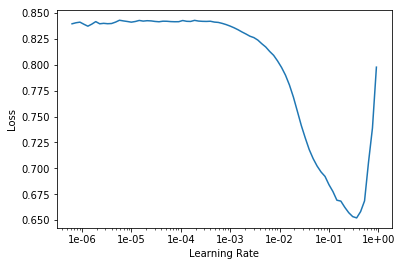

In [25]:
learn.recorder.plot()

In [26]:
lr = 1e-01

In [27]:
lr

0.1

In [28]:
learn.fit_one_cycle(10, max_lr=lr)

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


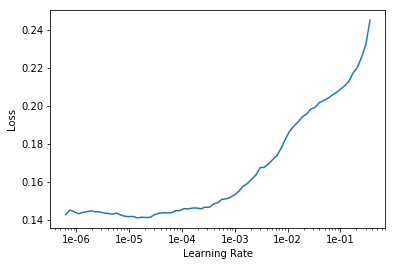

In [31]:
learn.recorder.plot()

In [34]:
lr = 1e-05

In [35]:
lr

1e-05

In [36]:
learn.fit_one_cycle(10, max_lr=lr)

In [37]:
learn.freeze()

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


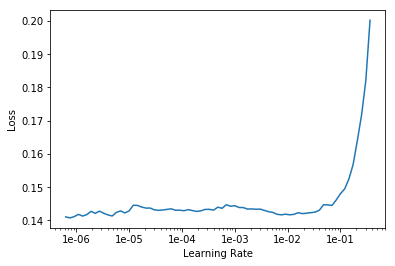

In [39]:
learn.recorder.plot()

In [40]:
lr = 1e-02

In [41]:
lr

0.01

In [42]:
learn.fit_one_cycle(10, max_lr=lr)

In [43]:
learn.unfreeze()

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


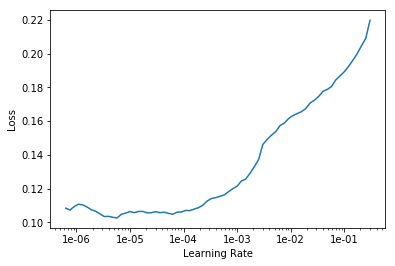

In [45]:
learn.recorder.plot()

In [46]:
lr = 1e-04

In [47]:
lr

0.0001

In [48]:
learn.fit_one_cycle(10, max_lr=lr)

In [49]:
learn.freeze()

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


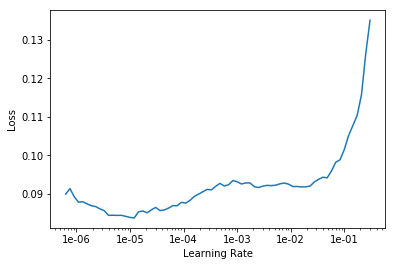

In [51]:
learn.recorder.plot()

In [54]:
lr = 1e-04

In [55]:
lr

0.0001

In [56]:
learn.fit_one_cycle(10, max_lr=lr)

In [57]:
learn.unfreeze()

In [58]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


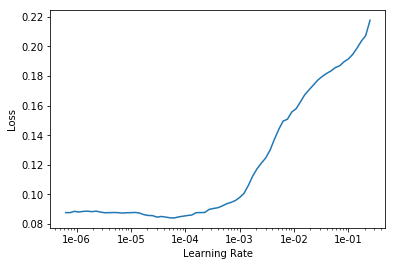

In [59]:
learn.recorder.plot()

In [60]:
lr = 1e-04

In [61]:
lr

0.0001

In [62]:
learn.fit_one_cycle(10, max_lr=lr)

In [63]:
learn.freeze()

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


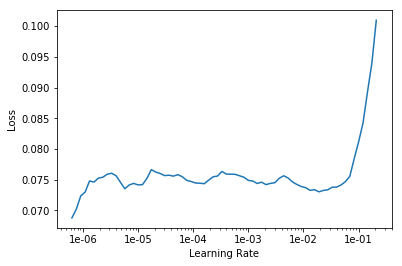

In [65]:
learn.recorder.plot()

In [66]:
lr = 1e-02

In [67]:
lr

0.01

In [68]:
learn.fit_one_cycle(10, max_lr=lr)

In [69]:
interp = ClassificationInterpretation.from_learner(learn)


In [71]:
interp.plot_multi_top_losses(1)

1 misclassified samples over 99 samples in the validation set.


IndexError: index 0 is out of bounds for axis 0 with size 0

In [73]:
learn.save('fontastic_resnet_34_256')

In [74]:
preds, _ = learn.get_preds(ds_type=DatasetType.Valid)

In [75]:
learn.data.valid_ds.items

array(['/home/paperspace/code/fontastic/data/training/Lora/Lora-Regular_50_rand_crop_0.jpg',
       '/home/paperspace/code/fontastic/data/training/Fahkwang/Fahkwang-ExtraLightItalic_80_rand_crop_1.jpg',
       '/home/paperspace/code/fontastic/data/training/Lato/Lato-Italic_300_rand_crop_3.jpg',
       '/home/paperspace/code/fontastic/data/training/Lora/Lora-Bold_150_rand_crop_7.jpg', ...,
       '/home/paperspace/code/fontastic/data/training/Fahkwang/Fahkwang-LightItalic_50_rand_crop_5.jpg',
       '/home/paperspace/code/fontastic/data/training/Merriweather/Merriweather-Bold_300_rand_crop_0.jpg',
       '/home/paperspace/code/fontastic/data/training/Fahkwang/Fahkwang-MediumItalic_50_rand_crop_9.jpg',
       '/home/paperspace/code/fontastic/data/training/Fahkwang/Fahkwang-Bold_50_rand_crop_6.jpg'], dtype='<U108')

In [76]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = [f for f in learn.data.valid_ds.items]
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
# dataframes.append(df)

In [79]:
df.iloc[0].image_name

'/home/paperspace/code/fontastic/data/training/Lora/Lora-Regular_50_rand_crop_0.jpg'

In [85]:
df['img'] = df['image_name'].apply(lambda x: x.split('/')[-1])

In [86]:
df

image_name  \
0   /home/paperspace/code/fontastic/data/training/...   
1   /home/paperspace/code/fontastic/data/training/...   
2   /home/paperspace/code/fontastic/data/training/...   
3   /home/paperspace/code/fontastic/data/training/...   
4   /home/paperspace/code/fontastic/data/training/...   
5   /home/paperspace/code/fontastic/data/training/...   
6   /home/paperspace/code/fontastic/data/training/...   
7   /home/paperspace/code/fontastic/data/training/...   
8   /home/paperspace/code/fontastic/data/training/...   
9   /home/paperspace/code/fontastic/data/training/...   
10  /home/paperspace/code/fontastic/data/training/...   
11  /home/paperspace/code/fontastic/data/training/...   
12  /home/paperspace/code/fontastic/data/training/...   
13  /home/paperspace/code/fontastic/data/training/...   
14  /home/paperspace/code/fontastic/data/training/...   
15  /home/paperspace/code/fontastic/data/training/...   
16  /home/paperspace/code/fontastic/data/training/...   
17  /home/paperspace/code/fontastic/data/training/...   
18  /home/paperspace/code/fontastic/data/training/...   
19  /home/paperspace/code/fontastic/data/training/...   
20  /home/paperspace/code/fontastic/data/training/...   
21  /home/paperspace/code/fontastic/data/training/...   
22  /home/paperspace/code/fontastic/data/training/...   
23  /home/paperspace/code/fontastic/data/training/...   
24  /home/paperspace/code/fontastic/data/training/...   
25  /home/paperspace/code/fontastic/data/training/...   
26  /home/paperspace/code/fontastic/data/training/...   
27  /home/paperspace/code/fontastic/data/training/...   
28  /home/paperspace/code/fontastic/data/training/...   
29  /home/paperspace/code/fontastic/data/training/...   
..                                                ...   
69  /home/paperspace/code/fontastic/data/training/...   
70  /home/paperspace/code/fontastic/data/training/...   
71  /home/paperspace/code/fontastic/data/training/...   
72  /home/paperspace/code/fontastic/data/training/...   
73  /home/paperspace/code/fontastic/data/training/...   
74  /home/paperspace/code/fontastic/data/training/...   
75  /home/paperspace/code/fontastic/data/training/...   
76  /home/paperspace/code/fontastic/data/training/...   
77  /home/paperspace/code/fontastic/data/training/...   
78  /home/paperspace/code/fontastic/data/training/...   
79  /home/paperspace/code/fontastic/data/training/...   
80  /home/paperspace/code/fontastic/data/training/...   
81  /home/paperspace/code/fontastic/data/training/...   
82  /home/paperspace/code/fontastic/data/training/...   
83  /home/paperspace/code/fontastic/data/training/...   
84  /home/paperspace/code/fontastic/data/training/...   
85  /home/paperspace/code/fontastic/data/training/...   
86  /home/paperspace/code/fontastic/data/training/...   
87  /home/paperspace/code/fontastic/data/training/...   
88  /home/paperspace/code/fontastic/data/training/...   
89  /home/paperspace/code/fontastic/data/training/...   
90  /home/paperspace/code/fontastic/data/training/...   
91  /home/paperspace/code/fontastic/data/training/...   
92  /home/paperspace/code/fontastic/data/training/...   
93  /home/paperspace/code/fontastic/data/training/...   
94  /home/paperspace/code/fontastic/data/training/...   
95  /home/paperspace/code/fontastic/data/training/...   
96  /home/paperspace/code/fontastic/data/training/...   
97  /home/paperspace/code/fontastic/data/training/...   
98  /home/paperspace/code/fontastic/data/training/...   

                                     tags  \
0                            Lora Regular   
1   ExtraLightItalic Fahkwang LightItalic   
2                        Italic Lato Lora   
3                               Bold Lora   
4                          Fahkwang Light   
5                         Lobster Regular   
6                     HairlineItalic Lato   
7                          Fahkwang Light   
8                Fahkwang Medium SemiBold   
9                             Italic Lato   
10           